# Step-by-Step Walkthrough of the *NextPitch* Prediction Model. 
### Welcome! 
#### This is a step by step demonstration of the *NextPitch Prediction Model*. If you are looking to rerun the project from top to bottom, just uncomment the commented cells and run!
---

## Importing the necessary libraries

In [1]:
import next_pitch
from next_pitch import library as lib
from next_pitch import pitch_functions
from next_pitch import data_collection
import os

Using TensorFlow backend.


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

---

## Load Data

The data used in this model is too large to store as a ```csv``` file on Github, so for the purpose of the walkthrough the data must be collected fresh by calling ```statsapi```. The function ```get_clean_data``` is a wrapper function for several other functions found in  ```data_collection.py``` . The functions pull in data, clean it and return a pandas data frame containing all pitches thrown in every Major League Baseball game during the specified period.

For demonstration, data from only the month of May 2018 will be used


In [3]:
pitch_data = data_collection.get_clean_data(start_date='05/01/2018', end_date='05/31/2018')

KeyboardInterrupt: 

In [ ]:
#pitch_data = data_collection.get_clean_data(start_date='03/28/2018', end_date='10/02/2018')

In [ ]:
len(pitch_data)

---

## Create Binary Labels for Pitch Prediction: Fastball = 1 and Offspeed = 0.

Using the ```binarize_target``` as the final cleaning measure for our data. This function turns the target variable 'pitch_type' into a a binary outcome. A pitcher's main goal to confuse the hitters timing, and by helping a hitter recognize fastball vs non-fastball that will go along way as to helping them become a better hitter.

This step wasn't added to the original data cleaning because I expect to classify 3 types of pitches in the next version of this product.

In [7]:
final_df = data_collection.binarize_target(pitch_data)

In [8]:
final_df.head()

,pitcher,WAR_x,WHIP,ERA,SO,hitter,SLG,OPS,WAR_y,about.atBatIndex,about.halfInning,about.inning,details.call.description,details.description,matchup.batSide.code,matchup.pitchHand.code,matchup.pitcher.id,matchup.splits.menOnBase,pitchData.nastyFactor,pitchData.zone,pitchNumber,pitch_type,prior_pitch_type,count
1,Kendrys Morales,0.0,1.0,0.0,0,Matt Chapman,0.508,0.864,8.2,70,top,9,Strike - Swinging,Foul,R,R,434778,Men_On,32.94,1.0,2.0,0.0,0.0,1.0-1.0
2,Kendrys Morales,0.0,1.0,0.0,0,Matt Chapman,0.508,0.864,8.2,70,top,9,Strike - Swinging,Foul,R,R,434778,Men_On,31.44,4.0,3.0,0.0,0.0,1.0-2.0
3,Kendrys Morales,0.0,1.0,0.0,0,Matt Chapman,0.508,0.864,8.2,70,top,9,Ball - Called,Ball,R,R,434778,Men_On,2.66,14.0,4.0,0.0,0.0,2.0-2.0
4,Kendrys Morales,0.0,1.0,0.0,0,Matt Chapman,0.508,0.864,8.2,70,top,9,Ball - Called,Ball,R,R,434778,Men_On,3.82,14.0,5.0,0.0,0.0,3.0-2.0
5,Kendrys Morales,0.0,1.0,0.0,0,Matt Chapman,0.508,0.864,8.2,70,top,9,Ball - Called,Ball,R,R,434778,Men_On,35.64,11.0,6.0,0.0,0.0,4.0-2.0


---

# Visualizing the Data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Heat Map of Pitches 

heat_x = final_df['pitchData.zone'].loc[final_df['about.inning']==1]

(array([ 780.,  354.,  474., 1089.,  434.,  438.,  468., 1341., 1132.,
        4152.]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <a list of 10 Patch objects>)

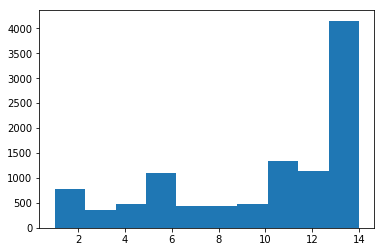

In [ ]:
plt.hist(heat_x)

In [ ]:
ax = sns.pairplot(data=final_df)

---

## Model Selection

Define the classifier that will be used to run the model. A gradient boosted trees model was selected because it performed the highest during the intial EDA period. Intial EDA can be found in ```next_pitch/parameter_tuning``` & ```next_pitch/final_model```.

In [ ]:
#classifier = lib.GradientBoostingClassifier(n_estimators=200, max_depth=10)

---

## Dropping Final Columns 

Dropping columns from the data frame that cannot be entered by the user via the web app. The model was trained on past data with results in order to help it build a knowledge base on how different pitches effect hitters. When the user inputs their data into the model, a dictionary with hardcoded averages from original dataset is added to fill in the gaps. This isn't a perfect solution, and will be addressed in later versions.

In [ ]:
final_df = final_df.drop(['about.atBatIndex', 'details.call.description', 'details.description', 
                                    'matchup.pitcher.id'], axis=1)

# Collection of testing data

Only data from 2019 is used in the test set so to avoid data leakage during the train test split.

In [ ]:
test_collect = data_collection.get_clean_data(start_date='05/01/2019', end_date='05/31/2019')

In [38]:
# test_data = data_collection.get_clean_data(start_date='05/01/2019', end_date='07/16/2019')

Drop columns so that the shape of ```test_data``` matches ```final_df```

In [ ]:
test_data = test_collect.drop(['about.atBatIndex', 'details.call.description', 'details.description', 
                                    'matchup.pitcher.id'], axis=1)

In [ ]:
test_data.head(5)

# Defining the test and target variables.
These are entered into the function as ```X_test``` & ```y_test```. By using current data, it ensures that the model has had absolelty zero interaction with the new data and will output the most accurate results.

In [ ]:
test_target = test_data['pitch_type']

In [ ]:
test_predictors = test_data.drop(['pitch_type'], axis=1).copy()

Creating a demo row for our model to predict upon. This is simulating the user input experience during deployment.

In [ ]:
testing = test_data['pitchData.nastyFactor'].fillna(35.5) #Average pitch nastiness

In [ ]:
testing = testing[-442:441]

# Final Modeling
The original model, which can be run directly below this cell was imported as a ```.pkl``` file and will be used to make predictions

In [ ]:
import pickle

In [ ]:
with open('next_pitch/web_app/final.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
model.predict_proba(testing)

# Evaluation

In [52]:
test_validation = test_data[-442:-441]['pitch_type']
test_validation

117612    Fastball
Name: pitch_type, dtype: object

----

### 1 = Fastball
### 0 = Off_Speed
### The model predicted a Fastball

---

# Run Original Model

In [325]:
#final_model = pitch_functions.final_model(X_test=test_predictors, y_test=test_target,final_df, classifier=classifier)